In [ ]:
import os
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4)
from tempfile import TemporaryFile
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
#DNM Code - Adapted from Deep Neural Maps (Pesteie et al 2018) for miRNA data

def load_mnist():
    (x, _), (_,_) = mnist.load_data()
    x = x / 255.
    return x.reshape((-1, 1, 28, 28))

def save_projection_image(memory, lattice_size, iter):
    width = memory.shape[2]
    height = memory.shape[1]
    proj_map = np.zeros((lattice_size[0] * height, lattice_size[1] * width))
    c = 0
    for i in range(lattice_size[0]):
        for j in range(lattice_size[1]):
            patch = memory[c]
            proj_map[
                i * height:(i + 1) * height, j * width:(j + 1) * width] = patch 
            c += 1
    plt.imshow(255*proj_map)
    plt.show()
    return proj_map


class Adam(object):
    def __init__(self, lr=1e-2, b1=9e-1, b2=0.999, e=1e-8, gamma=1 - 1e-8):
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.e = e
        self.gamma = gamma

    def updates(self, cost, params):

        updates = []
        grads = theano.grad(cost, params)
        alpha = self.lr
        t = theano.shared(np.float32(1))
        b1_t = self.b1 * self.gamma ** (t - 1)  # (Decay the first moment running average coefficient)

        for param, grad in zip(params, grads):
            m_previous = theano.shared(np.zeros(param.get_value().shape,
                                                dtype=theano.config.floatX))
            v_previous = theano.shared(np.zeros(param.get_value().shape,
                                                dtype=theano.config.floatX))

            m = b1_t * m_previous + (1 - b1_t) * grad  # (Update biased first moment estimate)
            v = self.b2 * v_previous + (1 - self.b2) * grad ** 2  # (Update biased second raw moment estimate)
            m_hat = 1.*m / (1 - self.b1 ** t)  # (Compute bias-corrected first moment estimate)
            v_hat = 1.*v / (1 - self.b2 ** t)  # (Compute bias-corrected second raw moment estimate)
            theta = param - (alpha * m_hat) / (T.sqrt(v_hat) + self.e)  # (Update parameters)

            updates.append((m_previous, m))
            updates.append((v_previous, v))
            updates.append((param, theta))
        updates.append((t, t + 1.))
        return updates

class BatchFactory(object):
    def __init__(self, batch_size, nb_samples, iterations, randomizer=True):
        self.BATCH_SIZE = batch_size
        self.nb_samples = nb_samples 
        self.iterations = iterations 
        self.randomizer = randomizer

    def _index_generator(self):
        for i in range(self.iterations):
            if self.randomizer:
                indices = np.random.permutation(self.nb_samples)
            else:
                indices = np.arange(self.nb_samples)
            for indexer in np.arange(self.nb_samples/self.BATCH_SIZE):
                indexer = int(indexer)
                yield indices[slice(indexer*self.BATCH_SIZE, (indexer+1)*self.BATCH_SIZE)]
            if self.nb_samples % self.BATCH_SIZE != 0:
                indexer = int(self.nb_samples / self.BATCH_SIZE)
                yield indices[slice(indexer*self.BATCH_SIZE, self.nb_samples)]

    def generate_batch(self, X, Y=None):
        Y = None
        for samples in self._index_generator():
            if Y is None:
                yield X[samples]
            else:
                yield X[samples], Y[samples]

class activations(object):
  def sigmoid(x):
    return T.nnet.sigmoid(x)

  def relu(x):
      return T.maximum(0.0, x)


def sigmoid(x):
    return T.nnet.sigmoid(x)

class Ops(object):

  def dense(inpt, nb_in, nb_out, layer_name='', init_params=None):
      if init_params is None:
          w = theano.shared(
              np.asarray(
                  np.random.normal(
                      loc=0, scale=np.sqrt(1. / nb_out), size=[nb_in, nb_out]),
                  dtype=theano.config.floatX),
              name='w_dense_' + layer_name, borrow=True)
          b = theano.shared(np.asarray(np.random.normal(
              loc=0.0, scale=1.0, size=[nb_out]),
              dtype=theano.config.floatX),
              name='b_dense_' + layer_name, borrow=True)
      else:
          w = init_params[0]
          b = init_params[1]
      return T.dot(inpt, w) + b, [w, b]


  def conv_2d_transpose(inpt, conv2d_params, stride=(1, 1), layer_name='', mode='valid', init_params=None):
    output_channel, input_channel, rows, columns = conv2d_params
    if init_params is None:
        filter_shape = (output_channel, input_channel, rows, columns)
        output_shape = (output_channel, input_channel, rows + 2, columns + 2)
        receptive_field_size = rows * columns

        w = theano.shared(np.asarray(
            np.random.normal(
                loc=0, scale=np.sqrt(2. / ((input_channel + output_channel) * receptive_field_size)),
            size=filter_shape),
            dtype=theano.config.floatX), name='w_conv2d_' + layer_name, borrow=True)

        b = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0.0, scale=1.0, size=(
                        filter_shape[0],)), dtype=theano.config.floatX),
            name='b_conv2d_' + layer_name, borrow=True)
    else:
        w = init_params[0]
        b = init_params[1]
    return T.nnet.conv2d_transpose(input=inpt, filters=w, output_shape=())


  def conv_2d(inpt, conv2d_params, stride=(1, 1), layer_name='', mode='valid', init_params=None):
      output_channel, input_channel, rows, columns = conv2d_params
      if init_params is None:
          filter_shape = (output_channel, input_channel, rows, columns)
          receptive_field_size = rows * columns

          w = theano.shared(np.asarray(
              np.random.normal(
                  loc=0, scale=np.sqrt(2. / ((input_channel + output_channel) * receptive_field_size)),
              size=filter_shape),
              dtype=theano.config.floatX), name='w_conv2d_' + layer_name, borrow=True)

          b = theano.shared(
              np.asarray(
                  np.random.normal(
                      loc=0.0, scale=1.0, size=(
                          filter_shape[0],)), dtype=theano.config.floatX),
              name='b_conv2d_' + layer_name, borrow=True)
      else:
          w = init_params[0]
          b = init_params[1]
      return T.nnet.conv2d(input=inpt, filters=w, border_mode=mode, subsample=stride) + b.dimshuffle('x', 0, 'x', 'x'), [w, b]


  def flatten(inpt, ndim=2):
    return T.flatten(inpt, ndim)


def get_params(layer_name, par_list):
  if par_list is None:
    return None
  pars = []
  for i in par_list:
    if i.name.split('_')[-1] == layer_name:
      pars.append(i)
  return None if len(pars) == 0 else pars

class SIMPLE_AE(object):


    def __init__(self, input_size, latent_size):
        self.input_size = input_size
        self.latent_size = latent_size

    def _encode(self, X, init_params):
        params = []
        regs = []
        e1, pars = Ops.conv_2d(X, (10, 1, 5, 5),
                               layer_name='e1',
                               mode='half',
                               init_params=get_params('e1', init_params))
        params += pars
        regs.append(pars[0])
        e2, pars = Ops.conv_2d(activations.relu(e1),
                               (8, 10, 5, 5),
                               layer_name='e2',
                               mode='half',
                               init_params=get_params('e2', init_params))
        params += pars
        regs.append(pars[0])
        e3, pars = Ops.conv_2d(activations.relu(e2),
                               (5, 8, 5, 5),
                               layer_name='e3',
                               mode='half',
                               init_params=get_params('e3', init_params))
        params += pars
        regs.append(pars[0])
        e4, pars = Ops.dense(Ops.flatten(activations.relu(e3)),
                             self.input_size[0] * self.input_size[1] * 5,
                             self.latent_size,
                             layer_name='e4',
                             init_params=get_params('e4', init_params))
        params += pars
        regs.append(pars[0])
        return e4, params, regs

    def _decode(self, X, init_params):
        params = []
        regs = []
        d4, pars = Ops.dense(
            X, self.latent_size, self.input_size[0] * self.input_size[1] * 5,
            layer_name='d4',
            init_params=get_params('d4', init_params))
        params += pars
        regs.append(pars[0])
        d4 = T.reshape((d4),
                       (-1, 5, self.input_size[0], self.input_size[1]))

        d3, pars = Ops.conv_2d(activations.relu(d4),
                               (8, 5, 5, 5),
                               layer_name='d3',
                               mode='half',
                               init_params=get_params('d3', init_params))
        params += pars
        regs.append(pars[0])
        d2, pars = Ops.conv_2d(activations.relu(d3),
                               (10, 8, 5, 5),
                               layer_name='d2',
                               mode='half',
                               init_params=get_params('d2', init_params))
        params += pars
        regs.append(pars[0])
        d1, pars = Ops.conv_2d(activations.relu(d2),
                               (1, 10, 5, 5),
                               layer_name='d1',
                               mode='half',
                               init_params=get_params('d1', init_params))
        params += pars
        regs.append(pars[0])
        return activations.sigmoid(d1), params, regs


class miRNA_AE(object): #Autoencoder for 1D data

    def __init__(self, input_size, latent_size):
        ae_layers = 3.0
        self.input_size = input_size
        self.latent_size = latent_size
        layer_list = []
        layer_list.append(self.input_size)

        #Arrange autoencoder steps in geometric series
        divis = pow((self.input_size / self.latent_size), (1 / ae_layers))
        for i in range(2):
            layer_list.append(int(layer_list[-1] / divis))
        self.layer_list = layer_list

    def get_params(layer_name, par_list):
      if par_list is None:
        return None
      pars = []
      for i in par_list:
        if i.name.split('_')[-1] == layer_name:
            pars.append(i)
      return None if len(pars) == 0 else pars


    def _encode(self, X, init_params):

        params = []
        regs = []
        e1, pars = Ops.dense(X, self.input_size, self.layer_list[1],
                               layer_name='e1',
                               init_params=get_params('e1', init_params))

        params += pars
        regs.append(pars[0])
        e2, pars = Ops.dense(activations.relu(e1),
                             self.layer_list[1],
                             self.layer_list[2],
                             layer_name='e2',
                             init_params=get_params('e2', init_params))

        params += pars
        regs.append(pars[0])
        e3, pars = Ops.dense(activations.relu(e2),
                             self.layer_list[2],
                             self.latent_size,
                             layer_name='e3',
                             init_params=get_params('e3', init_params))
        params += pars
        regs.append(pars[0])
        return e3, params, regs

    def _decode(self, X, init_params):

        params = []
        regs = []
        d3, pars = Ops.dense(
            X, self.latent_size, self.layer_list[2],
            layer_name='d3',
            init_params=get_params('d3', init_params))

        params += pars
        regs.append(pars[0])
        d2, pars = Ops.dense(activations.relu(d3),
            self.layer_list[2], self.layer_list[1],
            layer_name='d2',
            init_params=get_params('d2', init_params))

        params += pars
        regs.append(pars[0])
        d1, pars = Ops.dense(activations.relu(d2),
                             self.layer_list[1], self.input_size,
                             layer_name='d1',
                             init_params=get_params('d1', init_params))

        params += pars
        regs.append(pars[0])
        return sigmoid(d1), params, regs


class DNM(object):

    def __init__(self,
                 input_image_size,
                 latent_size,
                 lattice_size,
                 ae_arch_class,
                 name,
                 init_params=None,
                 sigma=None,
                 alpha=None,
                 BATCH_SIZE=64,
                 ae_lr=1e-3,
                 lmbd=1e-6,
                 som_pretrain_lr=0.0005,
                 dnm_map_lr=0.05):

        self.lattice_size = lattice_size
        self.name = name
        self.latent_size = latent_size
        self.sigma = sigma if sigma is not None else max(self.lattice_size[0],
                                                         self.lattice_size[1]) / 2.
        self.alpha = alpha if alpha is not None else 0.3
        self.input_image_size = input_image_size
        self.ae_lr = ae_lr
        self.lmbd = lmbd
        self.ae_arch_obj = ae_arch_class(self.input_image_size,
                                         self.latent_size)
        self.BATCH_SIZE = BATCH_SIZE
        self.som_lr = som_pretrain_lr
        self.dnm_map_lr = dnm_map_lr
        self.ae_weights = None
        if init_params is not None:
            self.ae_weights = init_params[0]
        if init_params is not None:
            self.som_weights = init_params[1]
        else:
            self.som_weights = theano.shared(np.random.normal(0, 1,
                                                              (self.lattice_size[0] *
                                                               self.lattice_size[
                                                                   1],
                                                               self.latent_size), ))
        if not os.path.exists('ckpts'):
            os.mkdir('ckpts')
        self._build()

    def __soft_probs(self, sample, clusters):
        alpha = 1.0
        q = 1.0 / \
            (1.0 + (T.sum(T.square((sample - clusters)), axis=1) / alpha))
        q **= (alpha + 1.0) / 2.0
        q = T.transpose(T.transpose(q) / T.sum(q, axis=0))
        return q

    def __kld(self, p, q):
        return T.sum(p * T.log(p / q), axis=-1)

    def __SOM(self, X, W, n, update_flag):

        learning_rate_op = T.exp(-1. * self.som_lr * n)
        _alpha_op = self.alpha * learning_rate_op
        _sigma_op = self.sigma * learning_rate_op

        locations = self.locs
        maps = T.sub(X, W)
        measure = T.sum(T.pow(T.sub(X, W), 2), axis=1)
        err = measure.min()
        self.bmu_index = T.argmin(measure)
        bmu_loc = locations[self.bmu_index]
        dist_square = T.sum(
            T.square(T.sub(locations, bmu_loc)), axis=1)
        H = T.cast(T.exp(-dist_square / (2 * T.square(_sigma_op))),
                   dtype=theano.config.floatX)
        w_update = W + _alpha_op * \
            T.tile(H, [self.latent_size, 1]).T * maps
        Qs = self.__soft_probs(X, W)
        P = Qs ** 2 / Qs.sum()
        P = (P.T / P.sum()).T
        cost = self.__kld(P, Qs)
        return [err, cost, bmu_loc], {W: update_flag * w_update + (1 - update_flag) * W}

    def _build_locs(self, m, n):
        for i in range(m):
            for j in range(n):
                yield(np.array([i, j]))

    def _build(self):
        # Tensors
        n = T.scalar()
        som_update_flag = T.scalar()
        #self.X = T.TensorType(dtype=theano.config.floatX, broadcastable=(False,) * 4)('X')
        self.X = T.TensorType(
            dtype=theano.config.floatX, broadcastable=(False,) * 2)('X')  #changed for 1D data

        # Architecture of the AE
        encoder_output, encoder_params, enc_to_regs = self.ae_arch_obj._encode(
            self.X, self.ae_weights)
        encoder_output_sigmoid = sigmoid(encoder_output)
        reconstructed, decoder_params, dec_to_regs = self.ae_arch_obj._decode(
            encoder_output_sigmoid, self.ae_weights)

        # Architecture of the SOM and updates
        self.locs = T.constant(
            [i for i in self._build_locs(self.lattice_size[0], self.lattice_size[1])])
        [self.__SOM_batch_errs, som_kl_cost, bmus], self.__SOM_updates = theano.scan(
            sequences=encoder_output_sigmoid,
            non_sequences=[self.som_weights, n, som_update_flag],
            fn=self.__SOM)

        # Loss of DNM, SOM and AE
        ae_optimizer = Adam(lr=self.ae_lr)
        self.ae_weights = encoder_params + decoder_params
        to_regs = enc_to_regs + dec_to_regs
        self.map_err = T.mean(som_kl_cost)
        #self.rec_cost = T.mean(
        #    T.sum(T.nnet.binary_crossentropy(reconstructed, self.X), axis=1))
        self.rec_cost = T.mean(T.sum((reconstructed - self.X) ** 2, axis=1)) #changed for 1D data
        self.ae_cost = self.rec_cost + self.lmbd * \
            np.array([T.sum(i) ** 2 for i in to_regs]).sum()

        self.dnm_cost = self.ae_cost + self.map_err

        dnm_updates = ae_optimizer.updates(cost=self.dnm_cost,
                                           params=self.ae_weights)

        ae_updates = ae_optimizer.updates(cost=self.ae_cost,
                                          params=self.ae_weights)
        # Train ops
        self.__train_op_dnm = theano.function([self.X, n, som_update_flag],
                                              outputs=[self.dnm_cost, T.mean(
                                                  self.__SOM_batch_errs)],
                                              updates=dnm_updates)
        self.__train_op_ae = theano.function([self.X],
                                             outputs=self.ae_cost,
                                             updates=ae_updates)
        self.__train_op_som = theano.function([self.X, n, som_update_flag],
                                              outputs=[self.__SOM_batch_errs, bmus],
                                              updates=self.__SOM_updates)

        self.__get_ae_output = theano.function([self.X],
                                               encoder_output_sigmoid)
        self.__get_reconstructed = theano.function([self.X],
                                                   reconstructed)
        self.__decode_embedding = theano.function([encoder_output_sigmoid],
                                                  reconstructed)
        self.__get_backprojection = theano.function([],
                                                     outputs=reconstructed,
                                                     givens={encoder_output_sigmoid: self.som_weights.eval().astype('float64')})

        self._get_bmu_locs = theano.function(
            [self.X, n, som_update_flag], bmus)

    def get_bmu_array(self, X):
        res = []
        weight_array = self.som_weights.get_value()
        for i in X:
            measure = np.sum((i - weight_array) ** 2, axis=1)
            bmu_index = np.argmin(measure)
            res.append(weight_array[bmu_index])
        return np.array(res)

    def train(self, x_train, 
              dnm_epochs, trial_name, name, location_name,
              pre_train_epochs=None):

        if pre_train_epochs is not None:
            self._pretrain(x_train, pre_train_epochs[
                           0], pre_train_epochs[1], trial_name, name, location_name, self.BATCH_SIZE)
            
        hold_inter = TemporaryFile() #save weights (deletes at the end of session)
        hold_int = [self.ae_weights, self.som_weights]
        np.save(hold_inter, hold_int)


        self.som_lr = self.dnm_map_lr
        print('\nTraining DNM')
        print(50 * '=')
        B = BatchFactory(self.BATCH_SIZE, len(x_train), dnm_epochs)
        batcher = B.generate_batch(x_train, None)
        iteration = 0
        nb_batches = np.ceil(1. * len(x_train) / self.BATCH_SIZE)
        errs = []
        Ds = []
        for idx, batch in enumerate(batcher):
            self.__train_op_som(batch, iteration, 1)
            er, dists = self.__train_op_dnm(batch, iteration, 0)
            errs.append(er)
            Ds.append(dists)
            if (idx + 1) % (nb_batches) == 0:
                print(
                    'iter: {} \tloss: {}, dist: {}'.format(iteration + 1, np.array(errs).mean(),
                                                           np.array(Ds).mean()))
                print(50 * '-')
                iteration += 1
                Ds = []
                errs = []
        
        hold_final = TemporaryFile() #save weights (deletes at the end of session)
        hold_fin = [self.ae_weights, self.som_weights]
        np.save(hold_final, hold_fin)


    def get_locations(self, input_vects):
        to_return = []
        weight_values = list(np.array(self.som_weights.eval()))
        locations = list(np.array(self.locs.eval()))
        test = self.__get_ae_output(input_vects.astype('float32'))
        for vect in test:
            #v = vect.reshape(1,1, self.input_image_size[0],self.input_image_size[1])

            v=vect
            min_index = min([i for i in range(len(weight_values))],
                             key=lambda x: np.linalg.norm(v -
                                                          weight_values[x]))
            
            to_return.append(locations[min_index])
        return to_return

    def get_reconstructed(self, X):
        return self.__get_reconstructed(X.astype('float32'))

    def decode_embedding(self, z):
        return self.__decode_embedding(z)

    def backproject_map(self):
        return self.__get_backprojection()

    def _pretrain(self, x_train, AE_epochs, SOM_epochs, trial_name, name, location_name, BATCH_SIZE=64):
        print('\nPre-training AE')
        print(50 * '=')
        B = BatchFactory(BATCH_SIZE, len(x_train), AE_epochs)
        batcher = B.generate_batch(x_train, None)
        iteration = 0
        nb_batches = np.ceil(1. * len(x_train) / BATCH_SIZE)
        errs = []
        for idx, batch in enumerate(batcher): 
            er = self.__train_op_ae(batch)
            errs.append(er)
            if (idx + 1) % (nb_batches) == 0:
                print('iter: {} \ttrain loss: {}'.format(iteration + 1,
                                                         np.array(errs).mean()))
                print(50 * '-')
                iteration += 1
                errs = []
      
        print('\nPre-training SOM')
        print(50 * '=')
        B = BatchFactory(BATCH_SIZE, len(x_train), SOM_epochs)
        batcher = B.generate_batch(x_train, None)
        iteration = 0
        nb_batches = np.ceil(1. * len(x_train) / BATCH_SIZE)
        errs = []
        
        for idx, batch in enumerate(batcher):
            ers, dists = self.__train_op_som(batch, iteration, 1)
            errs.append(np.mean(ers))
            if (idx + 1) % nb_batches == 0:
                print('iter: {} \ttrain loss: {}'.format(iteration + 1,
                                                         np.array(errs).mean()))
                print(50 * '-')
                iteration += 1
                errs = []
                

In [ ]:
X = sklearn.datasets.load_breast_cancer().data
Y = sklearn.datasets.load_breast_cancer().target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
 
nrm = MinMaxScaler()
X_train = nrm.fit_transform(X_train)
X_test = nrm.transform(X_test) 

lattice_size = (16,16)
latent_size = 4

deep_map = DNM(input_image_size= len(X_train[0]),
                        latent_size= latent_size,
                        lattice_size= lattice_size,
                        ae_arch_class= miRNA_AE, 
                        name='miRNA_test',
                        init_params=None, 
                        sigma=None,
                        alpha=None,
                        BATCH_SIZE=16,
                        ae_lr=1e-3,
                        lmbd=1e-6,
                        som_pretrain_lr=0.005,
                        dnm_map_lr=0.05)




deep_map.train(x_train=X_train.astype('float32'),  
                                dnm_epochs=1500, trial_name='test', name='test', location_name=None,
                                pre_train_epochs=[2500, 1500]) 


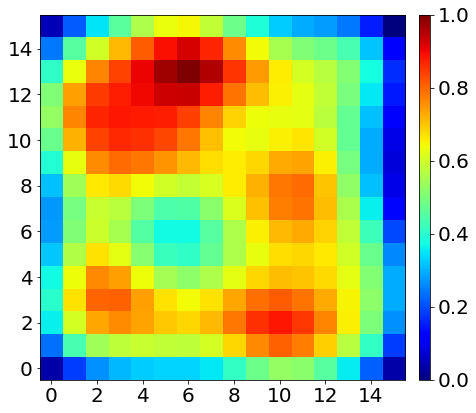

In [ ]:
def plot_classifier_neoplastic(classifier):
    f, (ax1) = plt.subplots(1, 1, figsize=(7, 7))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    im1 = ax1.imshow(classifier, cmap="jet")
    ax1.invert_yaxis()
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="3%", pad=0.2)
    cbar1 = plt.colorbar(im1, cax=cax1, format="%.1f")
    cbar1.ax.tick_params(labelsize=20)
    plt.show()

def compute_scaled_kde_neoplastic(lattice_size, locs_arr):
    x = np.arange(0, lattice_size[0])
    y = np.arange(0, lattice_size[1])
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([Y.ravel(), X.ravel()]).T
    kernel_normal = stats.gaussian_kde(locs_arr.T)
    Z = np.reshape(kernel_normal([positions[:, 0], positions[:, 1]]), X.shape)
    Z_scaled = (Z - Z.min()) / (Z.max() - Z.min())
    plot_classifier_neoplastic(Z_scaled)
    return Z, Z_scaled

#Obtain locations of samples and plot as a heatmap
locs = deep_map.get_locations(X_train.astype('float32')) 
_ = compute_scaled_kde_neoplastic(lattice_size, np.array(locs))


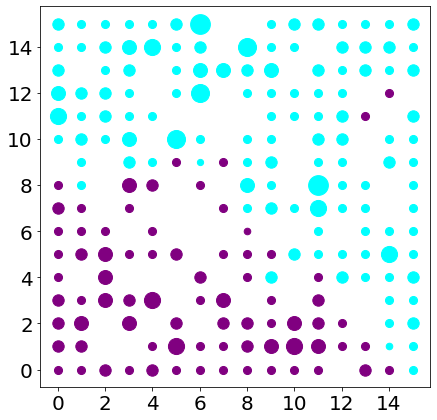

In [ ]:
def find_largest_activation(i, j, locs, labs):
  arr = [0] * len(set(labs))
  for l in range(len(locs)):
    x, y = locs[l]
    if x == i and y == j:
      arr[labs[l]] = arr[labs[l]] + 1
  num = np.argwhere(arr == np.amax(arr))
  
  if len(num) > 1:
    return "Blank", 0
  if np.sum(arr) == (np.max(arr)):
    return np.argmax(arr), np.max(arr)
  else:
    return np.argmax(arr), np.max(arr)/(np.sum(arr))
  
  


def labelled_plot(lattice_size, locs, labels, cols):
  for i in range(lattice_size[0]):
    for j in range(lattice_size[1]):
      win, num = find_largest_activation(i, j, locs, labels)
      if win != 'Blank':
        plt.figure(1, figsize=(7, 7))
        plt.scatter(j, i, s=num*65, color=cols[win])

  plt.xticks(np.arange(0,lattice_size[0],2),fontsize=20)
  plt.yticks(np.arange(0,lattice_size[1],2),fontsize=20)
  plt.show()

cols = ['purple', 'aqua']
labelled_plot(lattice_size, locs, y_train, cols)

In [ ]:
#Feature importance - can be done for entire network (all_types), or each different class (each_type)
#Method explained in Exploring microRNA Regulation of Cancer with Context-Aware Deep Cancer Classifier (Pyman et al. 2018)

def feat_vis(X_train): #First find output from AE, then backpropagate output through AE encoder layers to find activation of each input
  AE= miRNA_AE(len(X_train[0]), latent_size)
  ae_weights = np.array(deep_map.ae_weights)
  encoder_output, encoder_params, enc_to_regs = AE._encode(X_train.astype("float32"), ae_weights)
  all_summed_grads = []
  for i in range(len(X_train)):
    y = sigmoid(encoder_output[i])
    dy = T.jacobian(y,encoder_params)
    get_feat_vis = theano.function(inputs=[], outputs=dy)
    grads = get_feat_vis()[0]
    summed_grads = np.sum(np.abs(grads[0]), axis=1)
    all_summed_grads.append(summed_grads)
  final_sum = np.sum(all_summed_grads, axis=0)
  return final_sum

grad = feat_vis(X_train)
#Outputs activation of each miRNA for all samples
#Can input certain samples (ie, those of a single class) or individual samples for further analysis